In [41]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display 
import itertools
from IPython.display import display
import random
import operator
from random import choices, randint, randrange, random, sample, seed, uniform, choice
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial
sns.set()
import random
from itertools import product
import re
from collections import OrderedDict
from operator import getitem
from pprint import pprint
from numpy import asarray
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class MarketConfig: 
    #class attributes
    t0 = 2016 #The starting year for evaluation of the pay-offs
    T = 4#35  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2016, 2016 + T)
    distance = np.array([11810]) #nautical miles #Notteboom (2006)  
    port_time =  np.array([264])  #hours ==> 11 days in a year  #Notteboom (2006)
    demand_16_20 = np.array([1303780  for j in range(5)]) #in TEU #placehplder to be calibrated with the chosen route 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([1800])  ## in US$/TEU 
    SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter, demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        self.market_capacity = 0 
         
    
    def get_market_capacity (self, firm_instance):
        self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('./data/real_growth_rate.csv') #import IMF data
        #-------> 2.Construct GDP projection path 2016-2050 based on projection growth data 
        gdp_growth= G_df.values[:,1:] 
        g =1 +(gdp_growth/100)  
        self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        for foo in range (1,MarketConfig.T):
            self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([1.00 for j in range(MarketConfig.T)])
        for moo in range (1,MarketConfig.T):
            sub_g = g[:,0:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        self.market_demand = np.multiply(loo, MarketConfig.demand_16_20[0])
        #print(Y) # size = 1 dimesion array with size T=35 years
        self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_16_20[0] )
        return self.market_demand, self.gdp, self.market_psy

In [5]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, max_number_of_vessel, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        #self.bau_emission = bau_emission
         
   
    # Firm methods 
    def get_market_share(self , market_instance):
        '''return market share of the firm accoding to it s capacity'''
        self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        return self.market_share
        
    def get_firm_param(self, market_instance):
        self.psy = np.multiply (self.market_share , market_instance.market_psy)
        return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        #print(self.operational_speed)
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed) #returns a vector 
        #print( " operational_speed", self.operational_speed)
        #print( " self.time_at_sea", self.time_at_sea)
        self.voyage_time = self.time_at_sea + market_instance.port_time #returns a vector 
        self.number_of_trips_to_meet_demand = np.true_divide(self.firm_demand, self.capacity) #returns a vector
        self.max_trips_per_vessel = np.true_divide(market_instance.annual_working_time, self.voyage_time) #returns a vector
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel) #returns a vector
        #print("max_trips_per_vessel", self.max_trips_per_vessel)
        #print("min_number_of_vessel_to_meet_demand", self.min_number_of_vessel_to_meet_demand)
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand) #returns a vector
        #print("self.number_of_vessel", self.number_of_vessel)
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(market_instance.SFOC_main,market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        self.main_fuel_parameter = market_instance.SFOC_main * market_instance.eng_load_main * self.main_engine_power * 10**(-6)
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )  
        #print("self.ship_energy", self.ship_energy)
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        self.moo_1 = np.multiply(market_instance.distance, self.ship_energy)
        self.moo_2 = np.power(self.operational_speed, 2)
        self.moo_3 = np.multiply(self.moo_1, self.moo_2)
        self.main_fuel_cons = np.multiply(self.moo_3 , self.number_of_trips_to_meet_demand)
        #print("self.main_fuel_cons ", self.main_fuel_cons )
        return self.main_fuel_cons #returns a vector
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( market_instance.SFOC_aux, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6))
        self.aux_fuel_parameter = market_instance.SFOC_aux * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        #print("self.aux_fuel_cons",self.aux_fuel_cons)
        return self.aux_fuel_cons #returns a vector   
    
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        #print("self.fuel_cost", self.fuel_cost)
        return self.fuel_cost #returns a vector
    
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self.carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  
        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self.carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  
        self.carbon_emissions = self.carbon_main_emissions + self.carbon_aux_emissions 
        #print("self.carbon_emissions", self.carbon_emissions )
        return self.carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self.sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  
        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self.sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  
        self.sulfur_emissions = self.sulfur_main_emissions + self.sulfur_aux_emissions 
        #print("self.sulfur_emissions", self.sulfur_emissions)
        return self.sulfur_emissions      
    
            
    def get_total_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        #print("self.total_cost", self.total_cost)
        return self.total_cost #returns a vector    
     
                 
    def get_revenue(self,market_instance):
        self.revenue = np.multiply(self.firm_demand, market_instance.freight_rate)
        #print("self.revenue", self.revenue)
        return self.revenue #returns a vector
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        #print("self.period_profit", self.period_profit)
        return self.period_profit #returns a vector

# Inilize firm and market parmeters

In [6]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([5905]) 
max_number_of_vessel_1= np.array([100]) 
design_speed_1 = np.array([23.3]) #design speed of the vessel in knots
min_speed_1 = 10
max_speed_1 = 30
main_engine_power_1 =np.array([41186])  # main engine power in kW
aux_engine_power_1 =np.array([2433])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([6750000])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "HFO"
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([6470])
max_number_of_vessel_2 = np.array([100])
design_speed_2 = np.array([24.7])  #design speed of the vessel in knots
min_speed_2 = 10
max_speed_2 = 30
main_engine_power_2 = np.array([56273]) # main engine power in kW
aux_engine_power_2 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "HFO"
                    #===========================>  Firm 3 Attributes <==========================#
index_3 = 3
capacity_3 = np.array([6470])
max_number_of_vessel_3 = np.array([100])
design_speed_3 = np.array([24.7])  #design speed of the vessel in knots
min_speed_3 = 10
max_speed_3 = 30
main_engine_power_3 = np.array([56273]) # main engine power in kW
aux_engine_power_3 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_3 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_3 = "HFO"
                    #===========================> Market Attributes <==========================#
number_of_firms = 3
pollution_decay_parameter =  np.array([0.2])
pollution_damage_parameter =  np.array([1.5])
year  = MarketConfig.year
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([1800]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# Create simulation Objects

In [7]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, max_number_of_vessel_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1) 

firm_2 = Firm(index_2, capacity_2, max_number_of_vessel_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2) 

firm_3 = Firm(index_3, capacity_3, max_number_of_vessel_3, design_speed_3, 
                 min_speed_3, max_speed_3, main_engine_power_3, aux_engine_power_3,
                 fix_cost_3, fuel_type_3) 



game_config = MarketConfig(number_of_firms, pollution_decay_parameter, pollution_damage_parameter, income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
for  firm_object in Firm._registry:
    market_capacity_sim = game_config.get_market_capacity(firm_object)

# Market Demand

market demand [1303780.         1378613.27053661 1417081.19385409 1448735.913652  ]
firm 1 market share [0.31334572]
firm 2 market share [0.34332714]
firm 3 market share [0.34332714]


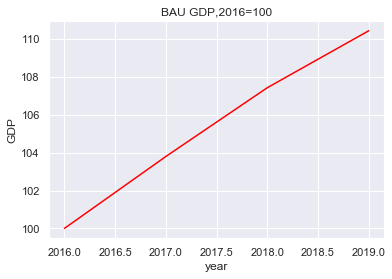

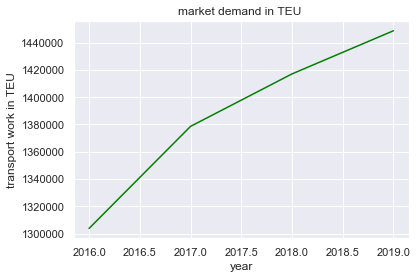

In [8]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
print("market demand", market_demand_sim)

# Get each firm's  market share  
firm_1_market_share_sim = firm_1.get_market_share(game_config)
print("firm 1 market share", firm_1_market_share_sim)

firm_2_market_share_sim = firm_2.get_market_share(game_config)
print("firm 2 market share", firm_2_market_share_sim)

firm_3_market_share_sim = firm_3.get_market_share(game_config)
print("firm 3 market share", firm_3_market_share_sim)

#======> Plotting BAU GDP,2016=100
sns.set()
ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
ax.set(xlabel='year', ylabel='GDP')
plt.title("BAU GDP,2016=100" )
plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("market demand in TEU " )
plt.show()

#======> Plotting Marketshare per firm



# Firms: Firm 1

firm 1 demand [408533.87635978 431982.56102514 444036.3199633  453955.19077289]
firm 1 ship energy [0.00053659]


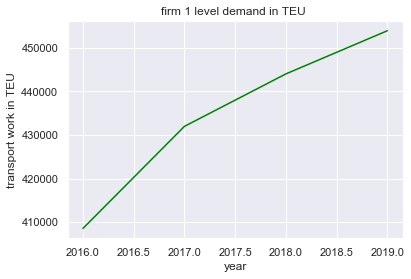

In [9]:
 # 7.Get firm passthrough parameter
firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
print("firm 1 ship energy", firm_1_ship_energy_sim)
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 1 level demand in TEU " )
plt.show()

# Firms: Firm 2

firm 2 demand [447623.06182011 473315.35475574 486522.4369454  497390.36143956]
firm 2 ship energy [0.00061541]


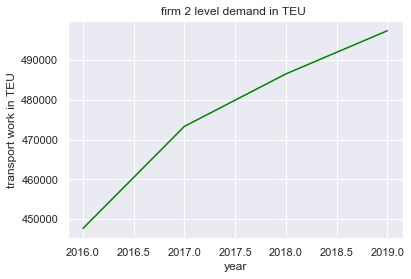

In [10]:
# 7.Get firm passthrough parameter
firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
print("firm 2 ship energy", firm_2_ship_energy_sim)
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_2_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 2 level demand in TEU " )
plt.show()

# Firms: Firm 3

firm 3 demand [447623.06182011 473315.35475574 486522.4369454  497390.36143956]
firm 3 ship energy [0.00061541]


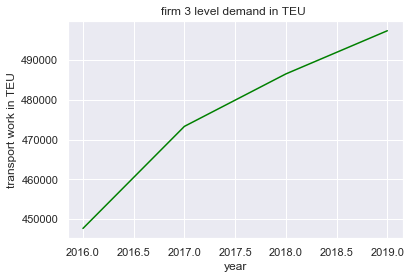

In [11]:
# 7.Get firm passthrough parameter
firm_3_psy_sim = firm_3.get_firm_param(game_config)

# 7.Get firm level demand  
firm_3_demand_sim = firm_3.get_firm_demand(game_config)
print("firm 3 demand", firm_3_demand_sim)


# 9.Get ship energy efficiency  
firm_3_ship_energy_sim = firm_3.get_ship_energy_efficiency(game_config)
print("firm 3 ship energy", firm_3_ship_energy_sim)
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_3_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 3 level demand in TEU " )
plt.show()

# A fine grained PGA (parallel genetic algorithm)

In [12]:
#====> Iinitialisation of chromo and population objects 
Chromo = List[float] 
Population = List[Chromo]
#====> Iinitialisation of function objects; Define the Objects; They allow you to pass in only what you need during the evol function 
PopulateFunc = Callable[[], Population]
VesselProc = Callable[[Chromo, Firm], Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray , np.ndarray ,np.ndarray, np.ndarray, np.ndarray]]
Best_Partner_And_Fitness_Func = Callable[[Chromo,int, int, Firm, dict] , dict]  
Integrated_Solution_Combo_Func = Callable[[dict, list , np.ndarray, np.ndarray,] , dict]

SelectionFunc = Callable[[np.ndarray, np.ndarray], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one
FitnessFunc = Callable[[Chromo], list] #int to refelct max # of vessel



### GA specific functions 

In [13]:
#======>
def generate_chromo(firm: Firm, vessel_proc: VesselProc) :
    while True:
        chromo = np.random.uniform(firm.min_speed, firm.max_speed, MarketConfig.T )  
        if (vessel_proc(chromo, firm)[0] != 0).all():
            break
        #print("chromo", chromo)
    return chromo  

#======>
def generate_population(vessel_proc: VesselProc, firm:Firm, size: int ):
    return  np.array([generate_chromo(firm, vessel_proc) for _ in range(size)])

#=====>
def selection_pair (chromo, weights):  
    selected_index = np.random.choice(np.arange(9),size = 2, replace=False,p= weights)
    #print("chromo[selected_index[0]]", chromo[selected_index[0]])
    #print("chromo[selected_index[1]", chromo[selected_index[1]])
    return chromo[selected_index[0]],chromo[selected_index[1]]

#=======>
def BLX_alpha_crossover (a: Chromo, b: Chromo, firm :Firm, sim_game) :
    child = np.zeros(sim_game.T)
    lower = np.zeros(sim_game.T)
    upper = np.zeros(sim_game.T)
    for i in range(sim_game.T): 
        lower[i] = (min(a[i],b[i])) - ( (0.5) * (max(a[i],b[i]) - min (a[i],b[i])))
        upper[i] = (max(a[i],b[i])) + ( (0.5) * (max(a[i],b[i]) - min (a[i],b[i])))
        lower[i] = firm.min_speed if (lower[i] < firm.min_speed) else lower[i]
        upper[i]= firm.max_speed if (upper[i] > firm.max_speed) else upper[i]
        child[i] = np.random.uniform (lower[i], upper[i])
    #print("child", child)
    
    return child

#=====>#mutation prob = 0.5
def mutation(chromo: Chromo, firm: Firm, sim_game, variance: float, probability: float = 0.1 ) : 
    mutated_chromo = np.zeros(sim_game.T)
    #print("chromo",chromo)
    for i in range(sim_game.T): 
        mutated_chromo[i] = np.random.normal(chromo[i], variance, 1) if random.random() > probability else chromo[i]
        #print("mutated_chromo ",mutated_chromo[i])
        mutated_chromo[i] = firm.min_speed  if mutated_chromo[i] < firm.min_speed  else mutated_chromo[i]
        mutated_chromo[i] = firm.max_speed if mutated_chromo [i] > firm.max_speed else mutated_chromo[i]
    #print("mutated_chromo", mutated_chromo)
    return mutated_chromo
#====> 
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result

### STACO specific functions 

In [14]:
def vessel_operation_procedure (chromo: Chromo, firm: Firm, sim_game: MarketConfig): 
    
    operational_speed_ = firm.update_vessel_speed(chromo)     
    #print("operational_speed", operational_speed_)
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game)
    #print(min_number_vessels_sim, trips_to_meet_demand_sim, time_at_sea_sim )
    number_vessels_sim  = firm.get_number_of_vessel()
    #print("max_number_of_vessel", firm.max_number_of_vessel)
    #print("number_vessels_sim", number_vessels_sim)
    
    if (number_vessels_sim > firm.max_number_of_vessel).any():
        #true 
        return np.zeros(9) #np.array([0,..,0])
    else:
        main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)
        #print("main_fuel_con_sim", main_fuel_con_sim)
        aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
        #print("aux_fuel_con_sim", aux_fuel_con_sim)
        fuel_cost_sim = firm.get_fuel_cost(sim_game) 
        #print("fuel_cost_sim", fuel_cost_sim)
        total_cost_sim = firm.get_total_cost()
        #print("total_cost_sim", total_cost_sim)
        revenue_sim = firm.get_revenue(sim_game)
        #print("revenue_sim", revenue_sim)
        profit_vector_sim = firm.get_period_profits()
        #print("profit_vector_sim", profit_vector_sim)
                        
        carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game) 
        #print("carbon_emissions_sim", carbon_emissions_sim)
        sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
        #print("sulfur_emissions_sim", sulfur_emissions_sim)
    return number_vessels_sim, main_fuel_con_sim, aux_fuel_con_sim, fuel_cost_sim, total_cost_sim , revenue_sim ,profit_vector_sim, carbon_emissions_sim, sulfur_emissions_sim

In [15]:
# objective function
def fitness(vessel_proc : VesselProc, 
            chromo_array, 
            sim_game,           
            carbon_pollution_decay_parameter,
            sulfur_pollution_decay_parameter,
            carbon_pollution_damage_parameter,
            sulfur_pollution_damage_parameter,
            initial_carbon_tax_sim,
            initial_sulfur_tax_sim,
            taxation_scheme_rate_sim):
    """get 3 chromos and returns payoffs"""
    discount_multiplier = np.power( 1+ sim_game.discount_rate, - np.arange(1,MarketConfig.T + 1))
    operations = [vessel_proc (chromo_array[firm.index -1 ], firm) for  firm in  Firm._registry ] 
    profits =  [operations[firm.index -1 ][6] for  firm in  Firm._registry ] 
    carbon_emissions =   [operations[firm.index -1 ][7] for  firm in  Firm._registry ] 
    #print("carbon_emissions",carbon_emissions)
    sulfur_emissions =   [operations[firm.index -1 ][8] for  firm in  Firm._registry ]   
    #print("sulfur_emissions", sulfur_emissions)
    
    #Indutry level 
    industry_carbon_emission = (np.sum(carbon_emissions, axis = 0)).reshape(-1)
    industry_sulfur_emission = (np.sum(sulfur_emissions, axis = 0)).reshape(-1)
    #print ("industry_carbon_emission", industry_carbon_emission)
    #print ("industry_sulfur_emission", industry_sulfur_emission)
        
    #pollution stock 
    carbon_pollution_stock=np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T
    sulfur_pollution_stock= np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T
    
    for my_period_index in range (MarketConfig.T-1):
        carbon_pollution_stock [my_period_index + 1] = (1- carbon_pollution_decay_parameter ) * carbon_pollution_stock[my_period_index ] + industry_carbon_emission[my_period_index]
        sulfur_pollution_stock [my_period_index + 1] = (1- sulfur_pollution_decay_parameter ) * sulfur_pollution_stock[my_period_index ] + industry_sulfur_emission[my_period_index]
    
    #print("carbon_pollution_stock", carbon_pollution_stock)
    #print("sulfur_pollution_stock", sulfur_pollution_stock)
    
    #dynamic tax
    carbon_dynamic_tax = np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T 
    sulfur_dynamic_tax = np.zeros(MarketConfig.T,  dtype=object) #[0]*MarketConfig.T
    
    carbon_dynamic_tax[0] = initial_carbon_tax_sim
    sulfur_dynamic_tax[0] = initial_sulfur_tax_sim
    for my_period_index in range (MarketConfig.T-1):
        carbon_dynamic_tax[my_period_index+1] = initial_carbon_tax_sim + (taxation_scheme_rate_sim * carbon_pollution_stock[my_period_index +1 ])
        sulfur_dynamic_tax[my_period_index+1] = initial_sulfur_tax_sim + (taxation_scheme_rate_sim * sulfur_pollution_stock[my_period_index +1 ])

    
    #print("carbon_dynamic_tax", carbon_dynamic_tax)
    #print("sulfur_dynamic_tax", sulfur_dynamic_tax)
    
    #### Get the industry s damages 
    industry_carbon_damages = 0.5* carbon_pollution_damage_parameter * np.power( carbon_pollution_stock,2)
    industry_sulfur_damages = 0.5* sulfur_pollution_damage_parameter * np.power( sulfur_pollution_stock,2)
 
    #print("industry_carbon_damages", industry_carbon_damages)
    #print("industry_sulfur_damages", industry_sulfur_damages)
    
    
    ### Get NPV for each firm 
        #print("tac", carbon_dynamic_tax )
        #print("carbon_emissions_sim ]", carbon_emissions_sim["firm" + str (firm.index)])
        #print ("check",  carbon_emissions_sim["firm" + str (firm.index)] * carbon_dynamic_tax )
    carbon_policy_cost = [np.multiply(carbon_emissions[firm.index - 1]  , carbon_dynamic_tax ) for firm in Firm._registry ] 
    #print("carbon_policy_cost",carbon_policy_cost)
    sulfur_policy_cost = [np.multiply(sulfur_emissions[firm.index - 1]  , sulfur_dynamic_tax ) for firm in Firm._registry ]
    #print("sulfur_policy_cost",sulfur_policy_cost)
    policy_cost = [carbon_policy_cost[firm.index - 1] + sulfur_policy_cost[firm.index - 1] for firm in Firm._registry ] 
    #print("policy_cost",policy_cost)
    period_profit = [profits[firm.index - 1]  -  policy_cost[firm.index - 1] for firm in Firm._registry ]  
    #print("period_profit", period_profit)
    discounted_period_profit = [np.multiply( discount_multiplier, period_profit[firm.index - 1]) for firm in Firm._registry]
    #print("discounted_period_profit", discounted_period_profit)
    payoff=[np.sum(discounted_period_profit[firm.index - 1]) for firm in Firm._registry] 
    #print("payoff", payoff)
    return payoff

In [16]:
def best_partner_selection_and_fitness_evaluation (vessel_proc : VesselProc, 
                                                   selected_chromo, 
                                                   selected_chromo_row_loc,
                                                   selected_chromo_column_loc, 
                                                   evolving_species, 
                                                   symbiotic_species, 
                                                   symbiotic_population,
                                                   sim_game, 
                                                   pop_grid_reshape_size,
                                                   carbon_pollution_decay_parameter,
                                                   sulfur_pollution_decay_parameter,
                                                   carbon_pollution_damage_parameter,
                                                   sulfur_pollution_damage_parameter,
                                                   initial_carbon_tax_sim ,
                                                   initial_sulfur_tax_sim ,
                                                   taxation_scheme_rate_sim) :


    #==========================================================================================================#
    ############################################ 0. Initilasiation ###########################################
    #==========================================================================================================#
    discount_multiplier = np.power( 1+ sim_game.discount_rate, - np.arange(1,MarketConfig.T + 1))
    #print(discount_multiplier)
    
    def getNPV(elem):
        return elem["NPV"]

    #==========================================================================================================#
    #### 1. Get operational results for the chromo to be evaluated of the respective firm  #############
    #==========================================================================================================#
    evolving_firm_vessel_operations = vessel_proc (selected_chromo,evolving_species)

     #==========================================================================================================#
    ########################################### 2. Symbiotic Spiecies   #######################################
    #==========================================================================================================#
    carbon_emissions_sim = {}
    sulfur_emissions_sim = {}
    symbiotic_neighberhood ={}
    candidate_partner_chromo = {}
    for _ in (symbiotic_species):
#========================> 2.1. Get Symbiotic Population in toroidal grid format <====================================#
        firm_symbiotic_pop = symbiotic_population["firm" + str(_.index)].reshape(pop_grid_reshape_size,
                                                                                 pop_grid_reshape_size,
                                                                                 MarketConfig.T)
        #print("firm_symbiotic_pop shaped to toroidal gris", firm_symbiotic_pop)
    
#===============> 2.2. Get Symbiotic Neighberhood range based on inital pt of evoluaion coordinatest <====================================#
        # A  structure of 3 × 3 neighborhood is used for the localized coevolutio
        neighberhood_row_selection_range = range(selected_chromo_row_loc - 1, selected_chromo_row_loc + 2 )
        neighberhood_column_selection_range = range(selected_chromo_column_loc - 1, selected_chromo_column_loc + 2 )
        #print("neighberhood_selection_range : ", neighberhood_row_selection_range, neighberhood_column_selection_range)
        
#========================> 2.3. Set Up the neighberhood for  Symbiotic Spiecies <====================================#
        # the neighborhood includs individual (m,n) and its eight neighbors in the sympioses  firm  pop
        # these are candidate partners for the fitness evaluation
        symbiotic_neighberhood= firm_symbiotic_pop.take(neighberhood_row_selection_range,
                                                        mode='wrap',
                                                        axis = 0).take(neighberhood_column_selection_range,
                                                                       mode='wrap',
                                                                       axis=1) 
        #print("symbiotic_neighberhood is ", symbiotic_neighberhood)
        
#========================>2.4. Get the 9 candidate partners for the fitness evaluaion [] <====================================#
        #reshape the neighberhood into 9 partner candidiate, A dict of the selected candidate partner chromos; 9 chromos for each firm 
        #candidate_partner_chromo["firm2":[.,.,.,] ,"firm3":[.,.,.,] ]
        candidate_partner_chromo["firm" + str(_.index)] = np.reshape(symbiotic_neighberhood
                                                                     , (9, MarketConfig.T )) #(l*m, n)
        #print("candidate_partner_chromo", _, candidate_partner_chromo)
        
#========================> 2.4. Get the 9 candidate partners for the fitness evaluaion [] <====================================#
        #Get candidate partner (symbiotic firms) period emission level based on their chromo
        carbon_emissions_sim["firm" + str(_.index)] ={}
        sulfur_emissions_sim["firm" + str(_.index)] = {}
        for partner_chromo_candidate_index in range(9):
            symbiotic_firm_vessel_operations = vessel_proc (candidate_partner_chromo["firm" + str(_.index)][partner_chromo_candidate_index], _)
            carbon_emissions_sim["firm" + str(_.index)] ["_chromo" + str(partner_chromo_candidate_index)] =  symbiotic_firm_vessel_operations[7] 
            sulfur_emissions_sim["firm" + str(_.index)] ["_chromo" + str(partner_chromo_candidate_index)] =  symbiotic_firm_vessel_operations[8]
            #print("carbon_emissions_sim for each firm", carbon_emissions_sim)
    
    #carbon_emissions_sim:{{firm2 :{chromo0 :[.,.,.,],...,  chromo8:[.,.,.,]} ,
    #                       firm3: {chromo0 :[.,.,.,],...,  chromo8:[.,.,.,]}} 
    
    #print("carbon_emissions_sim full dict", carbon_emissions_sim)
    #print("done boucle 1 ")
    #==========================================================================================================#
    ############################## 3.. Industry Level Pollution Computation    #################################
    #==========================================================================================================#
#========================================> 3.1.Create Combos <====================================#
    #Intilise the following dict for the evolving firm (ex : evolvin firm : firm 1) :
    #industry_carbon_emission_combo [{'firm2': '_chromo0'}, {'firm2': '_chromo1'}, 
    #{'firm2': '_chromo2'}, {'firm2': '_chromo3'}, {'firm2': '_chromo4'}, {'firm2': '_chromo5'}, 
    #{'firm2': '_chromo6'}, {'firm2': '_chromo7'}, {'firm2': '_chromo8'}]

    industry_carbon_emission_combo = [dict(zip(carbon_emissions_sim.keys(), a)) for a in itertools.product(*carbon_emissions_sim.values())]
     #industry_carbon_emission_combo is a list of dicts 
    
    #Update the the dict with the right emission values 
    for carbonindex in range(len(industry_carbon_emission_combo)):
        for firm in industry_carbon_emission_combo[carbonindex].keys():
            industry_carbon_emission_combo[carbonindex].update({str(firm): {str(industry_carbon_emission_combo[carbonindex][str(firm)]): 
                                 carbon_emissions_sim[str(firm)][str(industry_carbon_emission_combo[carbonindex][str(firm)])]}})
    
    #print("partners chromos cobination of emissions", industry_carbon_emission_combo )
    #print("done boucle 2")
    
  #========================================> 3.2. Compute industry level emissions <====================================#  
    firms = tuple(industry_carbon_emission_combo[0].keys())
    #print("firms are", firms)

    #print("evolving_firm_vessel_operations[7]", evolving_firm_vessel_operations[7])
#     print("Initilised dict", industry_carbon_emission_combo)
#     print("done boucle 3")
    
    carbon_emission_array = []
    for myindex in range(len(industry_carbon_emission_combo)):
        industry_carbon_emission_combo[myindex]["industry_carbon_emission"] ={}
        for firm in firms:
            chromos, firm_carbon_emission = tuple(zip(*industry_carbon_emission_combo[myindex][str(firm)].items()))
            #print("chromos", chromos)
            #print("firm_carbon_emission", firm_carbon_emission)
            carbon_emission_array.append(industry_carbon_emission_combo[myindex].get(str(firm)).get(str(chromos[0])))
            #print("carbon_emission_array",carbon_emission_array)
        industry_carbon_emission_combo[myindex]["industry_carbon_emission"] = evolving_firm_vessel_operations[7] + np.sum(carbon_emission_array, axis = 0) 
        
        carbon_emission_array =[]
    
    #print("industry level emissiom ; pollution sum ",industry_carbon_emission_combo)
    #print("done boucle 4")

#========================================> 3.2. Sulfur industry emissions <====================================#
    #get all possible combination
    industry_sulfur_emission_combo = [dict(zip(sulfur_emissions_sim.keys(), a)) for a in itertools.product(*sulfur_emissions_sim.values())]
    for sulfur_index in range(len(industry_sulfur_emission_combo)):
        for firm in industry_sulfur_emission_combo[sulfur_index].keys():
            industry_sulfur_emission_combo[sulfur_index].update({str(firm): {str(industry_sulfur_emission_combo[sulfur_index][str(firm)]): 
                                 sulfur_emissions_sim[str(firm)][str(industry_sulfur_emission_combo[sulfur_index][str(firm)])]}})

    
 #========================================> 3.2. Compute industry level emissions <====================================#  
    firms = tuple(industry_sulfur_emission_combo[0].keys())
    #print("industry_sulfur_emission_combo pre update",industry_sulfur_emission_combo)
    sulfur_emission_array = []
    for myindex in range(len(industry_sulfur_emission_combo)):
        industry_sulfur_emission_combo[myindex]["industry_sulfur_emission"] ={}
        for firm in firms:
            chromos, firm_sulfur_emission = tuple(zip(*industry_sulfur_emission_combo[myindex][str(firm)].items()))
            #print("chromos", chromos)
            #print("firm_sulfur_emission", firm_sulfur_emission)
            sulfur_emission_array.append(industry_sulfur_emission_combo[myindex].get(str(firm)).get(str(chromos[0])))
            #print("sulfur_emission_array",sulfur_emission_array)
        industry_sulfur_emission_combo[myindex]["industry_sulfur_emission"] = evolving_firm_vessel_operations[8] + np.sum(sulfur_emission_array, axis = 0) 
        sulfur_emission_array =[]
    
    #print("industry level emissiob",industry_sulfur_emission_combo)
    #print("done boucle 4")
    #==========================================================================================================#
    ##################################### 4. Policy Cost evaluation     #######################################
    #==========================================================================================================#
#===============================> 4.1. Carbon policy cost and pollution stock and damages <======================#
    #fitness of the chromo : 
 
    for  boo in range(len(industry_carbon_emission_combo)):
        industry_carbon_emission_combo[boo]["carbon_pollution_stock"] =np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[boo]["industry_carbon_damages"]= np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[boo]["carbon_dynamic_tax"]  = np.zeros (MarketConfig.T)
        industry_carbon_emission_combo[boo]["carbon_dynamic_tax"][0]  = initial_carbon_tax_sim    
        
        for my_period_index in range (MarketConfig.T-1): 
             #Remove and multipy instead of using loop 
            industry_carbon_emission_combo[boo]["carbon_pollution_stock"] [my_period_index + 1] = (1- carbon_pollution_decay_parameter ) * industry_carbon_emission_combo[boo]["carbon_pollution_stock"][my_period_index ] + industry_carbon_emission_combo[boo]["industry_carbon_emission"][my_period_index]
            industry_carbon_emission_combo[boo]["carbon_dynamic_tax"] [my_period_index+1] = initial_carbon_tax_sim + (taxation_scheme_rate_sim * industry_carbon_emission_combo[boo]["carbon_pollution_stock"][my_period_index +1 ])

        industry_carbon_emission_combo[boo]["industry_carbon_damages"] = 0.5* carbon_pollution_damage_parameter * np.power( industry_carbon_emission_combo[boo]["carbon_pollution_stock"],2)
        industry_carbon_emission_combo[boo]["carbon_policy_cost"] = np.multiply(evolving_firm_vessel_operations[7], 
                                                                    industry_carbon_emission_combo[boo]["carbon_dynamic_tax"]) # a numpy vectore
 
    #print("industry_carbon_emission_combo after update", industry_carbon_emission_combo)
 
#===============================> 4.2. sulfur policy cost and pollution stock and damages <=====================#
    for loo in range(len(industry_sulfur_emission_combo)):
        industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"] =np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[loo]["industry_sulfur_damages"]= np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"]  = np.zeros (MarketConfig.T)
        industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"][0]  = initial_sulfur_tax_sim
    
        for my_period_index in range (MarketConfig.T-1): 
            #Remove and multipy instead of using loop 
            industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"] [my_period_index + 1] = (1- sulfur_pollution_decay_parameter ) * industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"][my_period_index ] + industry_sulfur_emission_combo[loo]["industry_sulfur_emission"][my_period_index]
            industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"] [my_period_index+1] = initial_sulfur_tax_sim + (taxation_scheme_rate_sim * industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"][my_period_index +1 ])

        industry_sulfur_emission_combo[loo]["industry_sulfur_damages"] = 0.5* sulfur_pollution_damage_parameter * np.power( industry_sulfur_emission_combo[loo]["sulfur_pollution_stock"],2)
        industry_sulfur_emission_combo[loo]["sulfur_policy_cost"] = np.multiply(evolving_firm_vessel_operations[8], 
                                                                    industry_sulfur_emission_combo[loo]["sulfur_dynamic_tax"]) # a numpy vectore

    #print("industry_sulfur_emission_combo after update initial", industry_sulfur_emission_combo)
    #==========================================================================================================#
    ##################################### 5.Evolving Firm Update      #######################################
    #==========================================================================================================#
#===============================> 4.1. Carbon policy cost and pollution stock and damages <======================#
    #substitue the emission array with the candiidate partner speed array value
    #Original dict : firm1: chromo0: emissions ====> New dict: firm1:chromo0: vessel speed 
    #Turn updated chromo into a key 
    for koo in range(len(industry_carbon_emission_combo)):
        for firm in firms:
            chromos, chromo_tobe_updated = zip(*industry_carbon_emission_combo[koo][str(firm)].items())
            industry_carbon_emission_combo[koo][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]
    
    #print("industry_carbon_emission_combo after  2 update: what is this ??", industry_carbon_emission_combo)
    
#===============================> 4.2. sulfur policy cost and pollution stock and damages <=====================#
    #Update chromo for sulfur
    for koo2 in range(len(industry_sulfur_emission_combo)):
        for firm in firms:
            chromos, chromo_tobe_updated = zip(*industry_sulfur_emission_combo[koo2][str(firm)].items())
            industry_sulfur_emission_combo[koo2][str(firm)][str(chromos[0])] = candidate_partner_chromo[str(firm)][int(re.findall(r'\d+', chromos[0])[0])]
   
    #print("industry_sulfur_emission_combo after  2 update", industry_sulfur_emission_combo)
     
    #==========================================================================================================#
    ##################################### 6. final resuls     #######################################
    #==========================================================================================================#
#================================================> 6.1. Combine dicts <========================================#
    #consolidate resuls into 1 dict : pollution analysis 
    pollution_analysis = [{**a, **b} for a, b in zip(industry_carbon_emission_combo, industry_sulfur_emission_combo)]
    #print("pollution analysis consolidation", pollution_analysis )
#=======================================> 6.2. add pollution and update  cost and revenues <=====================#
    #Update pollution analysis with remaining info 
    #tHERE IS A BUG HERE ; MUST UPDATE WITH KEYS 
    for koo3 in range(len(pollution_analysis)):
        pollution_analysis[koo3]["policy_cost"] = pollution_analysis[koo3]["carbon_policy_cost"]+ pollution_analysis[koo3]["sulfur_policy_cost"] 
        pollution_analysis[koo3]["period_profit w/o a policy"] = evolving_firm_vessel_operations[6] 
        pollution_analysis[koo3]["period_profit"] = evolving_firm_vessel_operations[6]  -  pollution_analysis[koo3]["policy_cost"]
        pollution_analysis[koo3]["discounted_period_profit"]=  np.multiply( discount_multiplier,pollution_analysis[koo3]["period_profit"]  ) 
        pollution_analysis[koo3]["NPV"]= np.sum(pollution_analysis[koo3]["discounted_period_profit"])
        pollution_analysis[koo3]["vessel speed(chromo evaluated)"] = selected_chromo
        pollution_analysis[koo3]["number of vessels "] =evolving_firm_vessel_operations[0]
        pollution_analysis[koo3]["carbon emission "] =  evolving_firm_vessel_operations[7]
        pollution_analysis[koo3]["sulfur emission "] = evolving_firm_vessel_operations[8]
    
    #print("pollution analysis after adding info", pollution_analysis )
#=======================================> 6.3. Turn into a list and sort results from best to worst <=====================#
    #Sort dict 
    integrated_solution_list = sorted(pollution_analysis, key=getNPV, reverse = True )
    #print("integrated_solution_list; sort dict", integrated_solution_list)
    #==========================================================================================================#
    ###############7. Return a dict with the chromos and is partners      #######################################
    #==========================================================================================================#
    #integrated solution : partner firm1 : {chromoid: [.,.,]},
                          #partner firm2 : {chromoid: [.,.,]}, 
                          #industry_carbon_emission: [], 
                         #carbon_pollution_stock: [],
                        #industry_carbon_damages':
                        #carbon_dynamic_tax:
                        #carbon_policy_cost': 
                        #'industry_sulfur_emission': 
                        #'sulfur_pollution_stock':
                        #'industry_sulfur_damages':
                        #'sulfur_dynamic_tax': 
                        #'sulfur_policy_cost':
                        #'policy_cost' :  
                        #'period_profit:
                        #'discounted_period_profit':
                        #'NPV':
                        #'chromo evaluated '
                        #'sulfur emission '
                        #carbon emission
                        #number of vessels

            
#     print(integrated_solution_list[0])
#     print("=====")
#     print(integrated_solution_list[1])
#     print("+++++")
#     print(integrated_solution_list[2]) 
#     print("****")
    return integrated_solution_list[0]

In [17]:
def Coevo_GA(populate_func: PopulateFunc,
             vessel_proc: VesselProc,             
             best_partner_and_fitness_func: Best_Partner_And_Fitness_Func,  
             fitness_func : FitnessFunc, 
             mutation_func: MutationFunc,
             size,
             pop_grid_reshape_size,
             sim_game,
             generation_limit,
             selection_func: SelectionFunc = selection_pair,
             crossover_func: CrossoverFunc = BLX_alpha_crossover):
    
    #==========================================================================================================#
    ###################### 1.Initilize populations and create toroidal grids for each agents ####################
    #==========================================================================================================#
    #I.Initialise population :
    #1.Initilise population for each player and map population into a 2x2 lattice ; each chromo must have T genes 
    #2.map The population of each player into toroidal grids 
      # each population represents the coevolving solution communicating with other population,
     #Each of the populations forms a two-dimensional structure of toroidal square lattic
    #result :  3 population 
    population = {}
    population_ledger ={}   
    toroidal_grid_population_format = {}
    evolving_firm_fitness_evaluation ={}
    generation_number = 0
    my_chromo_combo ={}
    
    #generate population
    for firm_object in (Firm._registry):
        population["firm" + str(firm_object.index)] = (populate_func(vessel_proc,firm_object))
        toroidal_grid_population_format["firm" + str(firm_object.index)] = population["firm" + str(firm_object.index)].reshape(pop_grid_reshape_size,
                                                                                              pop_grid_reshape_size,
                                                                                              MarketConfig.T)#(sqrt(pop size) , sqrt(pop size), #of periods )
        population_ledger["firm" + str(firm_object.index)] = {}
        population_ledger["firm" + str(firm_object.index)]["generation"+ str(generation_number)] = copy.deepcopy(population["firm" + str(firm_object.index)] )
        my_chromo_combo["firm" +str(firm_object.index)] = {}
        
    #print("initial popo", population)
    #print("initial popo in toroidal grid format", toroidal_grid_population_format)
        

    #==========================================================================================================#
    ############################################ 4. Coevolutionnary Loop ######################################
    #==========================================================================================================#
#==========================================> 4.1. Coev loop Initilizaion  <=========================================#

    while (generation_number < generation_limit ) :
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++++++++++++>a) evolving Neighberhood Construction <++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#

    #a)  select the evolving spiecies, firm h,
        evolutionary_firm_index = (generation_number)%len(Firm._registry)
        evolving_species =Firm._registry[evolutionary_firm_index]
        #print("evolving_species",evolving_species)
        
    #b) identify the symbiotic spiecies
        symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
        
    #c) evolving population 
        evolving_population = toroidal_grid_population_format["firm" + str(evolving_species.index)]
        #print("evolving_population, should be in toroidal format",evolving_population, generation_number+1)
        
    #d)symbiotic population
        symbiotic_population = {}
        for _ in (symbiotic_species):
                symbiotic_population["firm" + str(_.index)] = toroidal_grid_population_format["firm" + str(_.index)]
     
        #print("symbiotic_population in grid format, this should remain the same as before",symbiotic_population, generation_number+1) 
    # e) Select an arbitrary location (m,n) from toroidal grids for firm h for which a neighborhood will be defined for the evolution process
        arbitrary_row_loc = randrange(pop_grid_reshape_size) 
        arbitrary_column_loc =  randrange(pop_grid_reshape_size) 
        #print("location of the initial point of fitness", arbitrary_row_loc, arbitrary_column_loc )
        
    #f) Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
        intial_point_of_evolution = toroidal_grid_population_format["firm" + str(evolving_species.index)][arbitrary_row_loc,
                                                                                    arbitrary_column_loc]
        #print("intial_point_of_evolution", intial_point_of_evolution)
    #g). Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]: the neighborhood including the center of evolution  and its 8 neighbors  
        #get selection range for the neighberhood selection
        neighberhood_row_selection_range = range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 )
        neighberhood_column_selection_range = range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 )

        #get Evolving Neighberhood
        evolving_neighberhood= evolving_population.take(neighberhood_row_selection_range,
                                                        mode='wrap',
                                                        axis = 0).take(neighberhood_column_selection_range,
                                                                       mode='wrap',
                                                                       axis=1) 
        #print("evolving_neighberhood", evolving_neighberhood)
        
    #h) get canidiate evolving chromos for the  genetic evolution 
        EN_chromo = np.reshape(evolving_neighberhood, (9, MarketConfig.T )) #(l*m, n)
        
        #print("candidate chromos for parents selection", EN_chromo)
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++>a) Fitness Evalution of the Evolving neighberhood against SN<+++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        EN_fitness_evaluation = {}
        i=-1
        for EN_candidate_chromo in EN_chromo: 
            i=i+1
            #print(evolving_species.index)
            EN_fitness_evaluation[i]= best_partner_and_fitness_func  (vessel_proc, 
                                              EN_candidate_chromo,
                                              arbitrary_row_loc,
                                              arbitrary_column_loc, 
                                              evolving_species, 
                                              symbiotic_species,
                                              symbiotic_population)
        #print(" fitness of the cadidate chromos", EN_fitness_evaluation)
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++>a) Parent Selection Process based on candidate chromo fitness <++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #Step 2: Select two parents from EN using the roulettewheel selection method based on fitness  
        gen = (inner_dict['NPV'] for inner_dict in EN_fitness_evaluation.values() )
        #get the sum of the fitness 
        sum_fitness = np.sum(np.fromiter(gen,float))
        #get the weight of each chromo 
        weights= np.hstack([inner_dict['NPV'] / sum_fitness  for inner_dict in EN_fitness_evaluation.values()])
        #print("weights are", weights)
        weights[np.isnan(weights)] = 0

        #print("max", max)
        #print("weights", weights)
        parents = selection_func(EN_chromo, weights = weights)
        #print("EN_chromo", EN_chromo)
        #print("parent are", parents) 
        
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++>a) Parents Crossover Process  <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #5. Crossover function: 
        #Generate 2 offspring by a crossover operation. 
        offspring_a = crossover_func(parents[0], parents[1],evolving_species, sim_game )
        offspring_b = crossover_func(parents[0], parents[1],evolving_species, sim_game)
        #print("offspring a are :" , offspring_a)
        #print("offspring b are :" , offspring_b)
        
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#++>a)Evaluate the fitness of the offsprings against the symbiotic neighberhood with the intial chosen location of the center of evolution  <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        offspring_a_evaluation ={}
        offspring_b_evaluation ={}
        offspring_a_evaluation["offspring a :" + str(offspring_a)]= best_partner_and_fitness_func  (vessel_proc,
                                                                offspring_a,
                                                                arbitrary_row_loc,
                                                                arbitrary_column_loc, 
                                                                evolving_species, 
                                                                symbiotic_species,
                                                                symbiotic_population)
        #print("offspring a evaluation", offspring_a_evaluation )
        
        offspring_b_evaluation["offspring b :" + str(offspring_b)]= best_partner_and_fitness_func  (vessel_proc,
                                                                offspring_b,
                                                                arbitrary_row_loc,
                                                                arbitrary_column_loc, 
                                                                evolving_species, 
                                                                symbiotic_species,
                                                                symbiotic_population)
        
        #print("offspring b evaluation", offspring_b_evaluation )

    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++>a) Replacement  Process  <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Get the worst 2 chromos in the EV: sort dict from bad to good and get the worst 2 
        sorted_EN = {}
        sorted_EN = OrderedDict(sorted(EN_fitness_evaluation.items(),key = lambda x: getitem(x[1], 'NPV'), reverse = False))
        #print("sorted EN", sorted_EN)
        worst_chromo_1 = list(sorted_EN.keys())[0]
        worst_chromo_2 = list(sorted_EN.keys())[1]
        worst_chromo_1_index = int(worst_chromo_1)
        worst_chromo_2_index = int(worst_chromo_2)
        
        #print("candidate evolving neighbourhood chromo", EN_chromo)
        #print("worst1:" , worst_chromo_1)
        #print("worst2", worst_chromo_2)
        
        #replace the worst chromo 
        EN_chromo[worst_chromo_1_index] = offspring_a
        EN_chromo[worst_chromo_2_index] = offspring_b
        #print("en after", EN_chromo)
        
        # Elitism: preserve the 2 best for the next evolving populaion 
        best_chromo_1 = list(sorted_EN.keys())[-1]
        best_chromo_1_index = int(best_chromo_1)
        #print ("best_chromo_1",best_chromo_1)


 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #+++++++++++++++++++>a) Mutation  Process to the individuals in EN <++++++++++++++++++++++++++++++++++++# 
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        for _ in range(len(EN_chromo)): 
            EN_chromo[_] = mutation_func(EN_chromo[_], evolving_species) if _ != best_chromo_1_index else EN_chromo[_]
         
        #print("mutated chromo",EN_chromo)
            
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++>a)Update the evolving population with the new chromos ++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#        
        #add the updated EN to he intial 
        #print("evolving_population before evoluion", evolving_population)
        index_eval=0
        for row in range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 ):
            row = row % pop_grid_reshape_size
            for column in range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 ): 
                column = column % pop_grid_reshape_size
                #print(row, column)
                toroidal_grid_population_format["firm" + str(evolving_species.index)][row][column] = EN_chromo[index_eval]
                index_eval += 1
        
        #print("evolving population after pop" ,toroidal_grid_population_format["firm" + str(evolving_species.index)])   

        #update the evolving population 
        population["firm" + str(evolving_species.index)] = np.reshape(toroidal_grid_population_format["firm" + str(evolving_species.index)], (size,sim_game.T)) 
        #print("population afer evolution", population)
        

#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++>a)Store the population  ++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#        
        
        for firm_object in (Firm._registry):
            population_ledger["firm" + str(firm_object.index)]["generation"+str(generation_number +1)] = copy.deepcopy(population['firm'+ str(firm_object.index)]) # updated_pop['firm'+ str(firm_object.index)]

        #print("population_ledger", population_ledger)
      #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
     #+++++++++++++++>a)Evaluae the new evolving population fitness and get the firm's partners++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#           
        #step 1: identify evolving spiecies, popylation and symbiotic spiecies 
        evolving_firm_fitness_evaluation["firm" + str(evolving_species.index)]={}
        
        #step 3: evaluate each chromo for evolving firm , 
        updated_row_loc = -1
        for updated_chromo_to_b_eval in toroidal_grid_population_format["firm" + str(evolving_species.index)]:  
            updated_row_loc = updated_row_loc + 1 
            for updated_split in range(pop_grid_reshape_size):
                #get the chromos from the pop
                updated_selected_chromo = updated_chromo_to_b_eval[updated_split]
                updated_column_loc = updated_split % pop_grid_reshape_size #mod  ;4
                #print("updated_selected_chromo", updated_selected_chromo)
                evolving_firm_fitness_evaluation["firm" + str(evolving_species.index)]["chromo"+str(updated_row_loc)+str(updated_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
                                                                                                                                                        updated_selected_chromo,
                                                                                                                                                        updated_row_loc,
                                                                                                                                                        updated_column_loc, 
                                                                                                                                                        evolving_species, 
                                                                                                                                                        symbiotic_species,
                                                                                                                                                        symbiotic_population)
                
        my_dict_evalcopy = copy.deepcopy(evolving_firm_fitness_evaluation)
        my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)]={}
        for chromo_index in (evolving_firm_fitness_evaluation['firm'+str(evolving_species.index)].keys()) :
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)] ={}
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"] = np.zeros(len(Firm._registry), dtype = object) 
            
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"][evolving_species.index -1] =  my_dict_evalcopy['firm'+str(evolving_species.index)][str(chromo_index)]['vessel speed(chromo evaluated)']
            symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
            for symbio  in symbiotic_species :
                my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"][symbio.index -1]= list((my_dict_evalcopy['firm'+str(evolving_species.index)][str(chromo_index)]["firm"+str(symbio.index)]).values())
                #get payoffs 
                #evaluate payoff 
            chromo_val = my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["chromocombo"]
            my_chromo_combo["firm" + str(evolving_species.index)]["generation"+str(generation_number +1)][str(chromo_index)]["payoff"] = fitness_func(vessel_proc, chromo_val )
        
        #print("evolving_firm_fitness_evaluation", evolving_firm_fitness_evaluation)    
        #print("my_chromo_combo",my_chromo_combo)
        generation_number +=1 
    
    last_integrated_solution = {}
    my_last_copy = copy.deepcopy(my_chromo_combo) 
    for _ in Firm._registry :
        last_gen_index = list(my_last_copy["firm" +str(_.index)])[-1]
        last_integrated_solution ["firm" +str (_.index)] =my_last_copy["firm" +str(_.index)][str(last_gen_index)]

    return population_ledger, my_chromo_combo,last_integrated_solution

# Run Evolution 

In [18]:
#pop_grid_reshape_size  = sqrt pop size 
population_ledger_evolution, my_chromo_combo, integrated_solution = Coevo_GA( 
    populate_func = partial(generate_population,
                            size=100),
    
    vessel_proc = partial(vessel_operation_procedure,
                          sim_game = game_config ),
    best_partner_and_fitness_func = partial(best_partner_selection_and_fitness_evaluation,
                                           sim_game = game_config, 
                                           pop_grid_reshape_size = 10,
                                           carbon_pollution_decay_parameter = 0.2,
                                           sulfur_pollution_decay_parameter=0.2,
                                           carbon_pollution_damage_parameter=1.5,
                                           sulfur_pollution_damage_parameter=1.5,
                                           initial_carbon_tax_sim =0,
                                           initial_sulfur_tax_sim =0,
                                           taxation_scheme_rate_sim=0),
    
    
     fitness_func= partial(fitness,
                           sim_game= game_config,   
                           carbon_pollution_decay_parameter = 0.2,
                                           sulfur_pollution_decay_parameter=0.2,
                                           carbon_pollution_damage_parameter=1.5,
                                           sulfur_pollution_damage_parameter=1.5,
                                           initial_carbon_tax_sim =0,
                                           initial_sulfur_tax_sim =0,
                                           taxation_scheme_rate_sim=0), 
    
    mutation_func = partial (mutation,
                             sim_game= game_config,
                             variance = 0.5,
                             probability = 0.1),
    size=100,
    pop_grid_reshape_size = 10,
    sim_game = game_config,
    generation_limit = 300)


#     integrated_solution_combo_func= partial(integrated_solution_combo_evaluation , 
#                                            sim_game = game_config),

In [19]:
integrated_solution['firm1']

{'chromo00': {'chromocombo': array([array([12.20887349, 11.11538904, 19.12495626, 17.09258481]),
         list([array([22.88387636, 27.05359899, 11.99949857, 15.97203629])]),
         list([array([26.10196515, 10.        , 17.46905301, 18.73189012])])],
        dtype=object),
  'payoff': [2428912122.602277, 2595220502.6273227, 2619808206.504629]},
 'chromo01': {'chromocombo': array([array([11.23648353, 13.98531029, 22.03385054, 17.72738389]),
         list([array([14.29550189, 24.67264081, 17.08699687, 17.48956276])]),
         list([array([13.43401449, 14.46700558, 21.24453379, 10.05369113])])],
        dtype=object),
  'payoff': [2408050160.916414, 2638000613.0065513, 2673407842.9296303]},
 'chromo02': {'chromocombo': array([array([17.31171787, 19.96721506, 20.36026942, 16.8561334 ]),
         list([array([16.46130681, 25.18223487, 18.37573557, 19.20711756])]),
         list([array([14.80753093, 16.43997539, 20.28412942, 18.18251038])])],
        dtype=object),
  'payoff': [240941875

# Coev Algo analysis

In [23]:
#population_ledger_evolution['firm1']['generation20']

In [22]:
population_ledger_evolution['firm1']['generation100'][98]

array([12.49202176, 25.86320135, 14.29006062, 18.97369145])

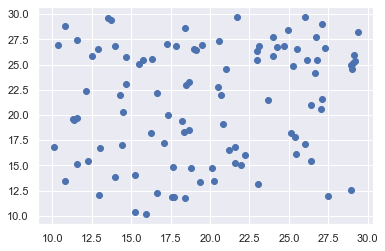

In [25]:
firm10 = [population_ledger_evolution['firm1']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm1']['generation0'])) ]
firm20 = [population_ledger_evolution['firm3']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm2']['generation0'])) ]
plt.scatter(firm20, firm10)

plt.show()

NameError: name 'sc' is not defined

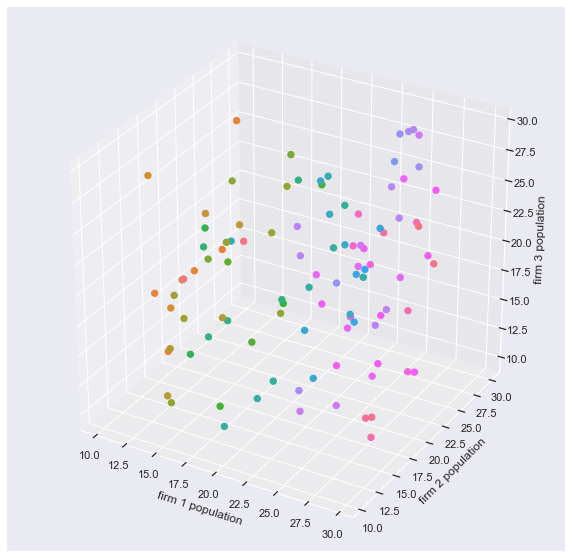

In [53]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection = '3d')
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

x = [population_ledger_evolution['firm1']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm1']['generation0']))] #df['Happiness Score']
y = [population_ledger_evolution['firm2']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm2']['generation0']))]
z = [population_ledger_evolution['firm3']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm3']['generation0']))] #df['Health (Life Expectancy)']

ax.set_xlabel("firm 1 population")
ax.set_ylabel("firm 2 population")
ax.set_zlabel("firm 3 population")

#ax.scatter(x, y, z) 
ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)


# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')
plt.show()


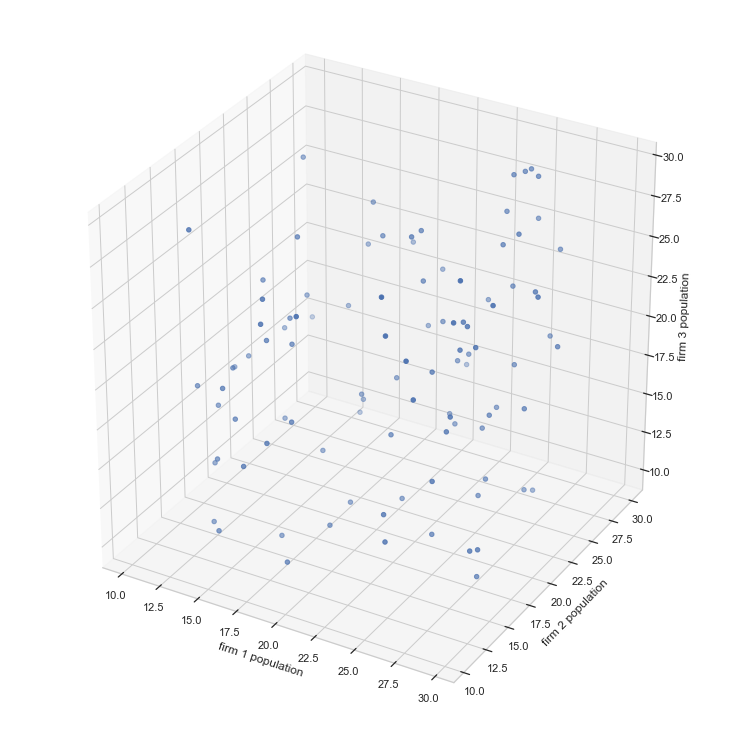

In [57]:
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set(style = "darkgrid")


fig = plt.figure(figsize=(10,10))

ax = Axes3D(fig)

x = [population_ledger_evolution['firm1']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm1']['generation0']))] #df['Happiness Score']
y = [population_ledger_evolution['firm2']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm2']['generation0']))]
z = [population_ledger_evolution['firm3']['generation0'][_][0] for _ in range(len(population_ledger_evolution['firm3']['generation0']))] #df['Health (Life Expectancy)']


g = ax.scatter(x, y, z, marker='o')
ax.set_xlabel("firm 1 population")
ax.set_ylabel("firm 2 population")
ax.set_zlabel("firm 3 population")


# produce a legend with the unique colors from the scatter
#legend = ax.legend(*g.legend_elements(), loc="lower center", title="X Values", borderaxespad=-10, ncol=4)
#ax.add_artist(legend)

plt.show()

In [ ]:
#Generation 100
firm1_100 = [population_ledger_evolution['firm1']['generation1000'][_][2] for _ in range(len(population_ledger_evolution['firm1']['generation100'])) ]
firm2_100 = [population_ledger_evolution['firm3']['generation1000'][_][2] for _ in range(len(population_ledger_evolution['firm2']['generation100'])) ]
plt.scatter(firm2_100, firm1_100)
plt.show()

In [ ]:
population_ledger_evolution['firm1']['generation1000'][98]

### Evaluatin GA performance

In [ ]:
plt.plot(results[1]["firm1"]['Generation'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Convergence " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Generation')
plt.show()
#############
plt.plot(results[1]["firm1"]['Vessel Speed'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Profits " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Vessel Speed')
plt.show()

# Convergance

## Selection of one integrated solution

In [ ]:
def pareto_agrement(integrated_solution):
    coev_dataframe = pd.DataFrame.from_dict({(j,i): integrated_solution[i][j] 
                                             for i in integrated_solution.keys() 
                                             for j in integrated_solution[i].keys()},
                                            orient='index')

    #drop duplicates
    coev_dataframe = coev_dataframe.loc[coev_dataframe.astype(str).drop_duplicates().index]
    #sort
    coev_dataframe = coev_dataframe.sort_values(by = 'payoff')
    #reindex
    coev_dataframe.reset_index(drop=True, inplace = True)
    #get payoff array
    payoff = np.array(coev_dataframe["payoff"])
    #get payoff length
    n_payoff = payoff.shape
    #initilise results 
    is_efficient = np.arange(len(payoff))
    next_point_index = 0  # Next index in the is_efficient array to search for

    while next_point_index < len(payoff):
        this_payoff = payoff[next_point_index]
        #print("this_payoff", this_payoff)

        # Two points `a` and `b` are *incomparable* if neither dom(a, b) nor dom(b, a).
        # Points that are incomparable to `this_cost`, or dominate `this_cost`.
         # In 2D, these points are below or to the left of `this_cost`.
        current_efficient_points = ([np.all(np.greater_equal(payoff[_], this_payoff)) for _ in range(len(payoff))])

        # Any point is incomparable to itself, so keep this point
        current_efficient_points[next_point_index] = True
        #print("current_efficient_points", current_efficient_points)

        # Remove dominated points
        is_efficient = is_efficient[current_efficient_points]
        #print("is_efficient", is_efficient)

        #Update candidate list 
        payoff = payoff[current_efficient_points]
        #print("payoff", payoff)

        # Re-adjust the index
        #print("current_efficient_points[:next_point_index]",current_efficient_points[:next_point_index])
        next_point_index = int(np.sum(current_efficient_points[:next_point_index]) + 1)
        #print('next_point_index', next_point_index)
        #print("======")

    
#     is_efficient_mask = np.zeros(n_payoff, dtype=np.bool_)
#     is_efficient_mask[is_efficient] = True
#     is_efficient_mask
    inegrated_solution_chromo = np.vstack(coev_dataframe["chromocombo"][int(is_efficient)])
    inegrated_solution_payoff = coev_dataframe["payoff"][int(is_efficient)]
    return coev_dataframe,is_efficient, inegrated_solution_chromo, inegrated_solution_payoff


In [ ]:
coev_dataframe,is_efficient, inegrated_solution_chromo, inegrated_solution_payoff = pareto_agrement(integrated_solution)
print("best chromo", inegrated_solution_chromo)
print("pareto payoff", inegrated_solution_payoff)
is_efficient

## Local search procedure

In [ ]:
def in_bounds(point, bounds ):
    # enumerate all dimensions of the point
    """get a chromo and return wether or not in the righ range"""
    check_min = np.all([point[_] >= bounds[0] for _ in range(len(point))])
    #print("check_min", check_min)
    check_max = np.all([point[_] <= bounds[1] for _ in range(len(point))])
    #print("check_max", check_max)
    check_chromo = np.all(check_max) and  np.all(check_min)
    #print("check_chromo", check_chromo)
    return check_chromo

In [ ]:
def rebound_chromo(chromo, firm):
    for i in range(len(chromo)):
        chromo[i] = firm.min_speed if (chromo[i] < firm.min_speed) else chromo[i]
        chromo[i]= firm.max_speed if (chromo[i] > firm.max_speed) else chromo[i]
    return chromo

In [ ]:
# hill climbing local search algorithm
def hillclimbing(fitness, bounds, n_iterations, step_size, start_pt):
    # store the initial point
    solution = start_pt
    # evaluate the initial point
    solution_eval = fitness( vessel_proc = partial(vessel_operation_procedure,
                          sim_game = game_config ),  
                        chromo_array = solution,
                        sim_game = game_config ,
                        carbon_pollution_decay_parameter = 0.2,
                        sulfur_pollution_decay_parameter=0.2,
                        carbon_pollution_damage_parameter=1.5,
                        sulfur_pollution_damage_parameter=1.5,
                        initial_carbon_tax_sim =0,
                        initial_sulfur_tax_sim =0,
                        taxation_scheme_rate_sim=0)
    
    # run the hill climb
    for i in range(n_iterations):
        # take a step
        candidate = np.array([solution[firm] + np.random.randn(MarketConfig.T) * step_size for firm in range(len(Firm._registry))])
        in_boundary = ([in_bounds(candidate[_], bounds[_])  for _  in range(len(Firm._registry))])

        while np.any(np.logical_not(in_boundary)): 
            is_in_boundary = np.arange(len(Firm._registry))
            is_in_boundary_index = is_in_boundary[np.logical_not(in_boundary)]

            for index in range(len(is_in_boundary_index)):
                bad_chromo_index = is_in_boundary_index[index]
                bad_firm = Firm._registry[bad_chromo_index]
                bad_chromo = candidate[bad_chromo_index]
                candidate[bad_chromo_index] = rebound_chromo(bad_chromo, bad_firm)
            
            in_boundary = ([in_bounds(candidate[_], bounds[_])  for _  in range(len(Firm._registry))])
       
        # evaluate candidate point
        candidate_eval = fitness( vessel_proc = partial(vessel_operation_procedure,
                          sim_game = game_config ),  
                        chromo_array = candidate,
                        sim_game = game_config ,
                        carbon_pollution_decay_parameter = 0.2,
                        sulfur_pollution_decay_parameter=0.2,
                        carbon_pollution_damage_parameter=1.5,
                        sulfur_pollution_damage_parameter=1.5,
                        initial_carbon_tax_sim =0,
                        initial_sulfur_tax_sim =0,
                        taxation_scheme_rate_sim=0)
        # check if we should keep the new point
        if (np.greater_equal(candidate_eval, solution_eval)).all():        
            # store the new point
            solution, solution_eval = candidate, candidate_eval
    return [solution, solution_eval]

In [ ]:
# iterated local search algorithm
def iterated_local_search(fitness, bounds, n_iter, step_size, n_restarts, p_size):
    # iterated local search algorithm
    #initlise Best chromo and best eval from Coev previous results 
    best_chromo = inegrated_solution_chromo #inegrated_solution_chromo
    
    # evaluate current best point
    best_eval = fitness( vessel_proc = partial(vessel_operation_procedure,
                                               sim_game = game_config ),  
                        chromo_array = best_chromo,
                        sim_game = game_config ,
                        carbon_pollution_decay_parameter = 0.2,
                        sulfur_pollution_decay_parameter=0.2,
                        carbon_pollution_damage_parameter=1.5,
                        sulfur_pollution_damage_parameter=1.5,
                        initial_carbon_tax_sim =0,
                        initial_sulfur_tax_sim =0,
                        taxation_scheme_rate_sim=0)


    # enumerate restarts
    for n in range(n_restarts):
        # generate an initial point as a perturbed version of the last best
        start_pt = np.array([best_chromo[firm] + np.random.randn(MarketConfig.T) * p_size for firm in range(len(Firm._registry))])
        in_boundary = ([in_bounds(start_pt[_], bounds[_])  for _  in range(len(Firm._registry))])
        #get index of the chromo to reupdate 

        while np.any(np.logical_not(in_boundary)): 
            is_in_boundary = np.arange(len(Firm._registry))
            is_in_boundary_index = is_in_boundary[np.logical_not(in_boundary)]
            
            #Boundary Update
            for index in range(len(is_in_boundary_index)):
                bad_chromo_index = is_in_boundary_index[index]
                bad_firm = Firm._registry[bad_chromo_index]
                bad_chromo = start_pt[bad_chromo_index]
                start_pt[bad_chromo_index] = rebound_chromo(bad_chromo, bad_firm)
            in_boundary = ([in_bounds(start_pt[_], bounds[_])  for _  in range(len(Firm._registry))])


        # perform a stochastic hill climbing search
        solution, solution_eval = hillclimbing(fitness, bounds, n_iter, step_size, start_pt)

        # check for new best
        if (np.greater_equal(solution_eval, best_eval)).all():
            best, best_eval = solution, solution_eval


    return [best, best_eval]

In [ ]:
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = [asarray([myfirm.min_speed , myfirm.max_speed ]) for myfirm in Firm._registry ]

# define the total iterations
n_iter = 5000
# define the maximum step size
s_size = 0.05
# total number of random restarts
n_restarts = 50
# perturbation step size
p_size = 1.0
# perform the hill climbing search
best, score = iterated_local_search(fitness, bounds, n_iter, s_size, n_restarts, p_size)
print('Done!')
#print('f(%s) = %f' % (best, score))

In [ ]:
best

In [ ]:
score

# Analysis

## c. Compute emissions throughout the planning horizon


In [ ]:
firms = optimum_solution[1].keys()
periodes = optimum_solution.keys()

##### Discounted Period Profits

In [ ]:
Discounted_period_profits = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Discounted_period_profits[firm][periode] = ((optimum_solution[periode][firm]["Firm Discounted profit"]).values).astype(float)
Discounted_period_profits

#####  Vessel Speed

In [ ]:
Vessel_speed_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        Vessel_speed_optimum[firm][periode] = ((optimum_solution[periode][firm]["Vessel Speed"]).values).astype(float)
Vessel_speed_optimum

#####  Number of vessels

In [ ]:
number_of_vessel_optimum = pd.DataFrame(columns = firms,  index = periodes )
for periode in periodes:
    for firm in firms:
        number_of_vessel_optimum[firm][periode] = ((optimum_solution[periode][firm]["Number of vessels"]).values).astype(float)
number_of_vessel_optimum

#####  Carbon Emissions Path

In [ ]:
carbon_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        carbon_emission[firm][periode] = ((optimum_solution[periode][firm]["Carbon Emissions"]).values).astype(float)

carbon_emission.to_csv("carbonemissionpath")


plt.plot(list(range(1,MarketConfig.T+1)),carbon_emission)
plt.title("Carbon emission path " )
plt.ylabel('Carbon emissions')
plt.legend(labels  =carbon_emission.columns.tolist())
plt.show()

carbon_emission

In [ ]:
### Sulfur Emission Path


In [ ]:
sulfur_emission = pd.DataFrame(columns = firms,  index = periodes )

for periode in periodes:
    for firm in firms:
        sulfur_emission[firm][periode] = ((optimum_solution[periode][firm]["Sulfur Emissions"]).values).astype(float)

        
plt.plot(list(range(1,MarketConfig.T+1)),sulfur_emission)
plt.title("Sulfur emission path " )
plt.ylabel('Sulfur emissions')
plt.legend(labels  = sulfur_emission.columns.tolist())
plt.show()



sulfur_emission.to_csv("sulfuremissionpath")
sulfur_emission

# Population evolution

In [ ]:
#####  Carbon and Sulfur Pollution Stock

In [ ]:
Pollution_Stock = pd.DataFrame(columns = ["Carbon Pollution Stock", "Sulfur Pollution Stock"] ,  index = periodes )

for periode in periodes:
    Pollution_Stock["Carbon Pollution Stock"][periode] = BAU_carbon_pollution_stock[periode -1]
    Pollution_Stock["Sulfur Pollution Stock"][periode] = BAU_sulfur_pollution_stock[periode -1]

# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel('Carbon Pollution Stock', color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Carbon Pollution Stock"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sulfur Pollution Stock', color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Pollution_Stock["Sulfur Pollution Stock"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Pollution_Stock

In [ ]:
#####  Carbon and Sulfur Pollution Damages

In [ ]:
Industry_Damages = pd.DataFrame(columns = ["Carbon Industry Damages", "Sulfur Industry Damages "] ,  index = periodes )

for periode in periodes:
    Industry_Damages["Carbon Industry Damages"][periode] = BAU_industry_carbon_damages[periode-1]
    Industry_Damages["Sulfur Industry Damages "][periode] = sulfur_industry_carbon_damages[periode-1]

    
    
# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('periode')
ax1.set_ylabel("Carbon Industry Damages", color=color)
ax1.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Carbon Industry Damages"] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Sulfur Industry Damages ", color=color)  # we already handled the x-label with ax1
ax2.plot(list(range(1,MarketConfig.T+1)), Industry_Damages["Sulfur Industry Damages "] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Industry_Damages

# Extras

In [ ]:
# # integrated_solution_combo_func : Integrated_Solution_Combo_Func, 

# def Coevo_GA(populate_func: PopulateFunc,
#              vessel_proc: VesselProc,             
#              best_partner_and_fitness_func: Best_Partner_And_Fitness_Func,  
#              fitness_func : FitnessFunc, 
#              mutation_func: MutationFunc,
#              size,
#              pop_grid_reshape_size,
#              sim_game,
#              generation_limit,
#              selection_func: SelectionFunc = selection_pair,
#              crossover_func: CrossoverFunc = BLX_alpha_crossover):
    
#     #==========================================================================================================#
#     ###################### 1.Initilize populations and create toroidal grids for each agents ####################
#     #==========================================================================================================#
#     #I.Initialise population :
#     #1.Initilise population for each player and map population into a 2x2 lattice ; each chromo must have T genes 
#     #2.map The population of each player into toroidal grids 
#       # each population represents the coevolving solution communicating with other population,
#      #Each of the populations forms a two-dimensional structure of toroidal square lattic
#     #result :  3 population 
#     population = {}
#     toroidal_grid_population_format = {}
#     #generate population
#     for firm_object in (Firm._registry):
#         population["firm" + str(firm_object.index)] = (populate_func(vessel_proc,firm_object))
#         toroidal_grid_population_format["firm" + str(firm_object.index)] = population["firm" + str(firm_object.index)].reshape(pop_grid_reshape_size,
#                                                                                               pop_grid_reshape_size,
#                                                                                               MarketConfig.T)#(sqrt(pop size) , sqrt(pop size), #of periods )
#     #print("initial popo", population)
#     #print("initial popo in toroidal grid format", toroidal_grid_population_format)
        
#     #==========================================================================================================#
#     ############################ 2.Initilize fitness evaluation  for each agents ##############################
#     #==========================================================================================================#
# #     Initial_fitness_evaluation ={}
# #     Initial_symbiotic_population = {}
# #     for firm_object in (Firm._registry): 
# #         #step 1: identify evolving spiecies, popylation and symbiotic spiecies 
# #         Initial_fitness_evaluation["firm" + str(firm_object.index)]={}
# #         Initial_evolving_species = firm_object
# #         Initial_symbiotic_species = [ _ for _ in Firm._registry if _ != Initial_evolving_species]
# #         Initial_evolving_population = population["firm" +  str(Initial_evolving_species.index)]
        
# #         #step 2: Identify symbiotic populations, 
# #         for _ in (Initial_symbiotic_species):
# #             Initial_symbiotic_population["firm" + str(_.index)] = population["firm" + str(_.index)]
        
# #         #step 3: evaluate each chromo for each firm , 
# #         Initial_row_loc = -1
# #         for chromo_to_b_eval in toroidal_grid_population_format["firm" + str(firm_object.index)]:  
# #             Initial_row_loc = Initial_row_loc + 1 
# #             for split in range(pop_grid_reshape_size):
# #                 #get the chromos from the pop
# #                 Initial_selected_chromo = chromo_to_b_eval[split]
# #                 Initial_column_loc = split % pop_grid_reshape_size #mod  ;4
                
# #                 Initial_fitness_evaluation["firm" + str(firm_object.index)]["chromo"+str(Initial_row_loc)+str(Initial_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
# #                                                                                                                                                     Initial_selected_chromo,
# #                                                                                                                                                     Initial_row_loc,
# #                                                                                                                                                     Initial_column_loc, 
# #                                                                                                                                              Initial_evolving_species, 
# #                                                                                                                                                     Initial_symbiotic_species,
# #                                                                                                                                                     Initial_symbiotic_population)
       
        
            
                
                
# #     #==========================================================================================================#
# #     ############################ 3.Get f_best Combination  for each agents ##############################
# #     #==========================================================================================================#
# #          #III. Seperate the dicts and sort population and find f_best
# #     Initial_sorted_population = {}
# #     f_best ={}

# # #     f_best["generation0"] = {}
# #     for firm_object in (Firm._registry): 
# #         f_best["firm" +str(firm_object.index)] ={}
# # #         f_best["generation0"]["firm" +str(firm_object.index)]={}
# #         Initial_sorted_population["firm" +str(firm_object.index)] = OrderedDict(sorted(Initial_fitness_evaluation["firm" + str(firm_object.index)].items(),key = lambda x: getitem(x[1], 'NPV'), reverse = True))
# # #         f_best["generation0"]["firm" +str(firm_object.index)]["NPV"] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['NPV']
# # #         f_best["generation0"]["firm" +str(firm_object.index)]["chromo"] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['vessel speed(chromo evaluated)']
# #         my_chromo_combo["firm" +str(firm_object.index)] = {}

# #         #could add fbest chromo
# #     #print("sorted population (initial )",Initial_sorted_population)
# #     #print("best",Initial_f_best)

# #      # returns a dict of the best fitness per firm
# #         #{'firm1': 82449112177.60916, 'firm2': 51399377630.082825, 'firm3': 78233116510.27917}
    
     
        

# #         f_best["firm" +str(firm_object.index)] ={}
# # #         f_best["generation0"]["firm" +str(firm_object.index)]={}
# #         Initial_sorted_population["firm" +str(firm_object.index)] = OrderedDict(sorted(Initial_fitness_evaluation["firm" + str(firm_object.index)].items(),key = lambda x: getitem(x[1], 'NPV'), reverse = True))
# # #         f_best["generation0"]["firm" +str(firm_object.index)]["NPV"] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['NPV']
# # #         f_best["generation0"]["firm" +str(firm_object.index)]["chromo"] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['vessel speed(chromo evaluated)']


# # #     f_best["generation0"] = {}
# #     for firm_object in (Firm._registry): 
# #         f_best["firm" +str(firm_object.index)] ={}
# # #         f_best["generation0"]["firm" +str(firm_object.index)]={}
# #         Initial_sorted_population["firm" +str(firm_object.index)] = OrderedDict(sorted(Initial_fitness_evaluation["firm" + str(firm_object.index)].items(),key = lambda x: getitem(x[1], 'NPV'), reverse = True))
# # #         f_best["generation0"]["firm" +str(firm_object.index)]["NPV"] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['NPV']
# # #         f_best["generation0"]["firm" +str(firm_object.index)]["chromo"] = Initial_sorted_population['firm'+str(firm_object.index)][str(list(Initial_sorted_population['firm'+str(firm_object.index)].keys())[0])]['vessel speed(chromo evaluated)']
# #         my_chromo_combo["firm" +str(firm_object.index)] = {}


#     #==========================================================================================================#
#     ############################################ 4.Inilise results ######################################
#     #==========================================================================================================#
#     my_chromo_combo ={}
#     for firm_object in (Firm._registry): 
#         my_chromo_combo["firm" +str(firm_object.index)] = {}

#     #==========================================================================================================#
#     ############################################ 4. Coevolutionnary Loop ######################################
#     #==========================================================================================================#
# #==========================================> 4.1. Coev loop Initilizaion  <=========================================#
#      #IV. Start the Coev loop
#         # the coevolving process runs for a predefined number of generations:
#         # the deviation of the chromosome for each species is smaller than the pre-specified threshold, ψ) == false:
#         #while (number_of_generation < generation_limit) or (chromo_deviation_chech() > deviation_threshold);
#         #(fitness_threshold_deviation > [0.1]).any() and
#        #fbest vector for each firm is no longer changing or genertation threshold
#     #fitness_threshold_deviation =  np.array([10000000000000000000]*sim_game.number_of_firms)
        
# #==========================================> 4.2. Begin Loop  <================================================#
#     evolving_firm_fitness_evaluation ={}
#     generation_number = 0
#     while (generation_number < generation_limit ) :
#         #f_best["generation" +str(generation_number+1)] = {}   
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #+++++++++++++++++++++++++>a) evolving Neighberhood Construction <++++++++++++++++++++++++++++++++# 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#

#     #a) randomy select a random firm h, the evolving spiecies
#         evolutionary_firm_index = (generation_number)%len(Firm._registry)
#         evolving_species =Firm._registry[evolutionary_firm_index]
#         #print("evolving_species",evolving_species)
        
#     #b) identify the symbiotic spiecies
#         symbiotic_species = [ _ for _ in Firm._registry if _ != evolving_species]
        
#     #c) evolving population 
#         evolving_population = toroidal_grid_population_format["firm" + str(evolving_species.index)]
#         #print("evolving_population, should be in toroidal format",evolving_population, generation_number+1)
        
#     #d)symbiotic population
#         symbiotic_population = {}
#         for _ in (symbiotic_species):
#                 symbiotic_population["firm" + str(_.index)] = toroidal_grid_population_format["firm" + str(_.index)]
     
#         #print("symbiotic_population in grid format, this should remain the same as before",symbiotic_population, generation_number+1) 
#     # e) Select an arbitrary location (m,n) from toroidal grids for firm h for which a neighborhood will be defined for the evolution process
#         arbitrary_row_loc = randrange(pop_grid_reshape_size) 
#         arbitrary_column_loc =  randrange(pop_grid_reshape_size) 
#         #print("location of the initial point of fitness", arbitrary_row_loc, arbitrary_column_loc )
        
#     #f) Identify the corrosponding chromo of the evolving firm "" chromo(m,n)" " as the center of evolution 
#         intial_point_of_evolution = toroidal_grid_population_format["firm" + str(evolving_species.index)][arbitrary_row_loc,
#                                                                                     arbitrary_column_loc]
#         #print("intial_point_of_evolution", intial_point_of_evolution)
#     #g). Set  up the Evolving Neighberhood from the evolving firm EN_mn[h]: the neighborhood including the center of evolution  and its 8 neighbors  
#         #get selection range for the neighberh
#ood selection
#         neighberhood_row_selection_range = range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 )
#         neighberhood_column_selection_range = range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 )
#         #get Evolving Neighberhood
#         evolving_neighberhood= evolving_population.take(neighberhood_row_selection_range,
#                                                         mode='wrap',
#                                                         axis = 0).take(neighberhood_column_selection_range,
#                                                                        mode='wrap',
#                                                                        axis=1) 
#         #print("evolving_neighberhood", evolving_neighberhood)
        
#     #h) get canidiate evolving chromos for the  genetic evolution 
#         EN_chromo = np.reshape(evolving_neighberhood, (9, MarketConfig.T )) #(l*m, n)
        
#         #print("candidate chromos for parents selection", EN_chromo)
        
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #+++++++++++++++>a) Fitness Evalution of the Evolving neighberhood against SN<+++++++++++++++# 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         EN_fitness_evaluation = {}
#         i=-1
#         for EN_candidate_chromo in EN_chromo: 
#             i=i+1
#             #print(evolving_species.index)
#             EN_fitness_evaluation[i]= best_partner_and_fitness_func  (vessel_proc, 
#                                               EN_candidate_chromo,
#                                               arbitrary_row_loc,
#                                               arbitrary_column_loc, 
#                                               evolving_species, 
#                                               symbiotic_species,
#                                               symbiotic_population)
#         #print(" fitness of the cadidate chromos", EN_fitness_evaluation)
        
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #+++++++++++++++>a) Parent Selection Process based on candidate chromo fitness <++++++++++++++++# 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #Step 2: Select two parents from EN using the roulettewheel selection method based on fitness  
#         gen = (inner_dict['NPV'] for inner_dict in EN_fitness_evaluation.values() )
#         #get the sum of the fitness 
#         sum_fitness = np.sum(np.fromiter(gen,float))
#         #get the weight of each chromo 
#         weights= np.hstack([inner_dict['NPV'] / sum_fitness  for inner_dict in EN_fitness_evaluation.values()])
#         #print("weights are", weights)
#         weights[np.isnan(weights)] = 0

#         #print("max", max)
#         #print("weights", weights)
#         parents = selection_func(EN_chromo, weights = weights)
#         #print("parent are", parents) 
        
        
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #++++++++++++++++++++++++++++>a) Parents Crossover Process  <++++++++++++++++++++++++++++++++++++# 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #5. Crossover function: 
#         #Generate 2 offspring by a crossover operation. 
#         offspring_a = crossover_func(parents[0], parents[1],evolving_species, sim_game )
#         offspring_b = crossover_func(parents[0], parents[1],evolving_species, sim_game)
#         #print("offspring a are :" , offspring_a)
#         #print("offspring b are :" , offspring_b)
        
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
# #++>a)Evaluate the fitness of the offsprings against the symbiotic neighberhood with the intial chosen location of the center of evolution  <++++++++++++++++++++++++++++++++++++# 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         offspring_a_evaluation ={}
#         offspring_b_evaluation ={}
#         offspring_a_evaluation["offspring a :" + str(offspring_a)]= best_partner_and_fitness_func  (vessel_proc,
#                                                                 offspring_a,
#                                                                 arbitrary_row_loc,
#                                                                 arbitrary_column_loc, 
#                                                                 evolving_species, 
#                                                                 symbiotic_species,
#                                                                 symbiotic_population)
#         #print("offspring a evaluation", offspring_a_evaluation )
        
#         offspring_b_evaluation["offspring b :" + str(offspring_b)]= best_partner_and_fitness_func  (vessel_proc,
#                                                                 offspring_b,
#                                                                 arbitrary_row_loc,
#                                                                 arbitrary_column_loc, 
#                                                                 evolving_species, 
#                                                                 symbiotic_species,
#                                                                 symbiotic_population)
        
#         #print("offspring b evaluation", offspring_b_evaluation )

#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #++++++++++++++++++++++++++++>a) Replacement  Process  <++++++++++++++++++++++++++++++++++++# 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#         # Get the worst 2 chromos in the EV: sort dict from bad to good and get the worst 2 
#         sorted_EN = {}
#         sorted_EN = OrderedDict(sorted(EN_fitness_evaluation.items(),key = lambda x: getitem(x[1], 'NPV'), reverse = False))
#         #print("sorted EN", sorted_EN)
#         worst_chromo_1 = list(sorted_EN.keys())[0]
#         worst_chromo_2 = list(sorted_EN.keys())[1]
#         worst_chromo_1_index = int(worst_chromo_1)
#         worst_chromo_2_index = int(worst_chromo_2)
        
#         #print("candidate evolving neighbourhood chromo", EN_chromo)
#         #print("worst1:" , worst_chromo_1)
#         #print("worst2", worst_chromo_2)
        
#         #replace the worst chromo 
#         EN_chromo[worst_chromo_1_index] = offspring_a
#         EN_chromo[worst_chromo_2_index] = offspring_b
#         #print("en after", EN_chromo)
        
#         # Elitism: preserve the 2 best for the next evolving populaion 
#         best_chromo_1 = list(sorted_EN.keys())[-1]
#         best_chromo_1_index = int(best_chromo_1)
#         #print ("best_chromo_1",best_chromo_1)


 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #+++++++++++++++++++>a) Mutation  Process to the individuals in EN <++++++++++++++++++++++++++++++++++++# 
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         for _ in range(len(EN_chromo)): 
#             EN_chromo[_] = mutation_func(EN_chromo[_], evolving_species) if _ != best_chromo_1_index else EN_chromo[_]
         
#         #print("mutated chromo",EN_chromo)
            
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#         #++++++++++++++++++++>a)Update the evolving population with the new chromos ++++++++++++++++++++++++++#
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#        
#         #add the updated EN to he intial 
#         #print("evolving_population before evoluion", evolving_population)
#         index_eval=0
#         for row in range(arbitrary_row_loc - 1, arbitrary_row_loc + 2 ):
#             row = row % pop_grid_reshape_size
#             for column in range(arbitrary_column_loc - 1, arbitrary_column_loc + 2 ): 
#                 column = column % pop_grid_reshape_size
#                 #print(row, column)
#                 toroidal_grid_population_format["firm" + str(evolving_species.index)][row][column] = EN_chromo[index_eval]
#                 index_eval += 1
        
#         #print("evolving population after pop" ,toroidal_grid_population_format["firm" + str(evolving_species.index)])   

#         #update the evolving population 
#         population["firm" + str(evolving_species.index)] = np.reshape(toroidal_grid_population_format["firm" + str(evolving_species.index)], (size,sim_game.T)) 
#         #print("population afer evolution", population)
        
                
    
    
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#      #+++++++++++++++>a)Evaluae the new evolving population fitness and get the firm's partners++++++++++++++++++++++++++#
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#           
#         #step 1: identify evolving spiecies, popylation and symbiotic spiecies 
#         evolving_firm_fitness_evaluation["firm" + str(evolving_species.index)]={}
        
#         #step 3: evaluate each chromo for evolving firm , 
#         updated_row_loc = -1
#         for updated_chromo_to_b_eval in toroidal_grid_population_format["firm" + str(evolving_species.index)]:  
#             updated_row_loc = updated_row_loc + 1 
#             for updated_split in range(pop_grid_reshape_size):
#                 #get the chromos from the pop
#                 updated_selected_chromo = updated_chromo_to_b_eval[updated_split]
#                 updated_column_loc = updated_split % pop_grid_reshape_size #mod  ;4
#                 evolving_firm_fitness_evaluation["firm" + str(evolving_species.index)]["chromo"+str(updated_row_loc)+str(updated_column_loc)] = best_partner_and_fitness_func (vessel_proc, 
#                                                                                                                                                         updated_selected_chromo,
#                                                                                                                                                         updated_row_loc,
#                                                                                                                                                         updated_column_loc, 
#                                                                                                                                                         evolving_species, 
#                                                                                                                                                         symbiotic_species,
#                                                                                                                                                         symbiotic_population)
#         #print("evolving_firm_fitness_evaluation", evolving_firm_fitness_evaluation)
            
                    
#         generation_number +=1
        
        
    
    
#       #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#      #+++++++++++++++>a)End of loop ++++++++++++++++++++++++++#
#     #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#           

    
#     #III. Seperate the dicts and sort population and find f_best
#     #get the chromos 
#     #f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)] ={}
    
#     for my_firm in Firm._registry: 
#         for chromo_index in (evolving_firm_fitness_evaluation['firm'+str(my_firm.index)].keys()) :
#             my_chromo_combo["firm" + str(my_firm.index)][str(chromo_index)] ={}
#             my_chromo_combo["firm" + str(my_firm.index)][str(chromo_index)]["chromocombo"] = np.zeros(len(Firm._registry), dtype = object) 
#             my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["chromocombo"][my_firm.index -1] = evolving_firm_fitness_evaluation['firm'+str(my_firm.index)][str(chromo_index)]['vessel speed(chromo evaluated)']
#             symbiotic_species = [ _ for _ in Firm._registry if _ != my_firm]
#             for symbio  in symbiotic_species :
#                 my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["chromocombo"][symbio.index -1]=list((evolving_firm_fitness_evaluation['firm'+str(my_firm.index)][str(chromo_index)]["firm"+str(symbio.index)]).values())
           
#             #get payoffs 
#             #evaluate payoff 
#             chromo_val = my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["chromocombo"]
#             print("chromo_val", chromo_val)
#             my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["payoff"] = fitness_func(vessel_proc, chromo_val )

        
            
            

#     return my_chromo_combo



# #         #III. Seperate the dicts and sort population and find f_best
# #         updated_sorted_population = {}
# #         #Results inialisation 
# #         f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)] ={}
     
# #         #Result Initi: 
# #         f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)]["chromocombo"]= [0]*len(Firm._registry)
# #         #f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)]["payoff"]= [0]*len(Firm._registry)
        
# #         #Order Dict 
# #         updated_sorted_population["firm" +str(evolving_species.index)] = OrderedDict(sorted(evolving_firm_fitness_evaluation["firm" + str(evolving_species.index)].items(),key = lambda x: getitem(x[1], 'NPV'), reverse = True))
        
# #         #Get chromos 
# #         f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)]["chromocombo"][evolving_species.index -1] = updated_sorted_population['firm'+str(evolving_species.index)][str(list(updated_sorted_population['firm'+str(evolving_species.index)].keys())[0])]['vessel speed(chromo evaluated)']

# #         for symbio  in symbiotic_species :
# #             f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)]["chromocombo"][symbio.index -1] = list((updated_sorted_population['firm'+str(evolving_species.index)][str(list(updated_sorted_population['firm'+str(evolving_species.index)].keys())[0])]["firm"+str(symbio.index)]).values())
        
       
# #         #return payoff 
# #         my_chromo_combo = f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)] ['chromocombo']
        
# #         #evaluate payoff 
# #         f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)]["payoff"]= fitness_func(vessel_proc, my_chromo_combo)
       
    
# #         #print("the updated_sorted_population dict", updated_sorted_population)
# #             #population size, ie 100           
# #             f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)][str(chromo_index)] ={}
# #             #print("my_chromo_combo", my_chromo_combo)
# #             for symbio  in symbiotic_species :
# #                 my_chromo_combo[int_index][symbio.index -1]=list((evolving_firm_fitness_evaluation['firm'+str(evolving_species.index)][str(chromo_index)]["firm"+str(symbio.index)]).values())
            
# #             #print("my_chromo_combo", my_chromo_combo)
                 
            
#             #add the chromo to the dict 
# #             f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)][str(chromo_index)]['chromocombo'] =  my_chromo_combo["firm" +str(evolving_species.index)]["generation"+str(generation_number)][str(chromo_index)]
            
            
# #             #add the payoff to the dict 
       
        
    
#         #\print("generation_number", generation_number)



In [ ]:
      #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
     #+++++++++++++++>a)End of loop ++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#              
    #III. Seperate the dicts and sort population and find f_best
    #get the chromos 
    #f_best["firm" +str(evolving_species.index)]["generation"+str(generation_number)] ={}
    
#     for my_firm in Firm._registry: 
#         for chromo_index in (evolving_firm_fitness_evaluation['firm'+str(my_firm.index)].keys()) :
#             my_chromo_combo["firm" + str(my_firm.index)][str(chromo_index)] ={}
#             my_chromo_combo["firm" + str(my_firm.index)][str(chromo_index)]["chromocombo"] = np.zeros(len(Firm._registry), dtype = object) 
#             my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["chromocombo"][my_firm.index -1] = evolving_firm_fitness_evaluation['firm'+str(my_firm.index)][str(chromo_index)]['vessel speed(chromo evaluated)']
#             symbiotic_species = [ _ for _ in Firm._registry if _ != my_firm]
#             for symbio  in symbiotic_species :
#                 my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["chromocombo"][symbio.index -1]=list((evolving_firm_fitness_evaluation['firm'+str(my_firm.index)][str(chromo_index)]["firm"+str(symbio.index)]).values())
           
#             #get payoffs 
#             #evaluate payoff 
#             chromo_val = my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["chromocombo"]
#             #print("chromo_val", chromo_val)
#             my_chromo_combo["firm" +str(my_firm.index)][str(chromo_index)]["payoff"] = fitness_func(vessel_proc, chromo_val )
